
# Capstone Final 24.1 — Modelling
### ----------------------------------------------------------
- Title: Buy vs Rent Decision Modeling
- Author: Siddarth R Mannem
- Course: AI/ML Professional Certificate - Capstone 24.1
### ----------------------------------------------------------
# 02_cost_projection_model.ipynb
**Buy vs. Rent in 2025–2026: ZIP-Level Cash-Flow Comparison**  

### Purpose
Establish a **course-aligned** modeling pipeline that predicts the **5-year NPV cost difference** between buying and renting at the ZIP level and provides a decision view (Buy vs Rent). The notebook is designed to be transparent, reproducible, and grounded in methods taught in **Modules 1–23**.

### Description
1. **Deterministic Baseline (Finance Engine):** Compute 5-year **NPV cash flows** for buying vs renting, incorporating mortgage payments, property tax, insurance, maintenance, growth assumptions, and discounting.  
2. **Feature Engineering:** Build interpretable features (e.g., price-to-rent) leveraging available columns in `master_housing_dataset_clean.csv`.  
3. **Course-Aligned Models:** Fit and compare **Linear Regression (OLS)**, **Ridge**, **Lasso**, **Elastic Net**, **Random Forest**, and **Gradient Boosted Trees** for the regression target. Provide an **optional Logistic Regression** for the classification decision.  
4. **Validation:** Use **GroupShuffleSplit** by geography (state/metro) to estimate generalization. Evaluate with **MAE, RMSE, R²** (regression) and **Accuracy, ROC AUC** (classification).  
5. **Explainability:** Use model **coefficients** and **permutation importance** to understand which features most influence the NPV cost difference, applying only the explainability methods taught in this course.

### Goals
- Produce a **robust, finance-grounded** target (`delta_buy_minus_rent`: NPV over 5 years).  
- Compare **interpretable vs nonlinear** models within course scope and pick a **default champion**.  
- Save **artifacts** for downstream **03_scenario_analysis.ipynb** (sensitivity sweeps on rates, tax, insurance).





In [1]:

# ------------------------------
# CONFIG: Import, Config, Paths & Settings
# ------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import (
accuracy_score, roc_auc_score, confusion_matrix, classification_report,
r2_score, mean_absolute_error, mean_squared_error)

pd.set_option('display.float_format', lambda x: '%.4f' % x)

drive.mount('/content/drive')
capstone_data_base_path = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/'
capstone_figures_base_path = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/figures/'
capstone_figures_model = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/figures/model/'

fig_dir = Path("figures"); fig_dir.mkdir(exist_ok=True)
artifacts_dir = Path("artifacts"); artifacts_dir.mkdir(exist_ok=True)

DATA_PATH  = Path(capstone_data_base_path + 'master_housing_dataset_clean.csv')
ARTIFACTS  = Path(capstone_data_base_path + 'artifacts')
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# Horizon & economic assumptions (baseline). Adjust as needed.
CONFIG = {
    "horizon_years": 5,
    "loan_term_years": 30,
    "discount_rate_yr": 0.03,      # NPV discounting
    "down_payment_pct": 0.20,
    "closing_cost_pct": 0.02,
    "selling_cost_pct": 0.06,
    "maintenance_rate_yr": 0.01,   # default if missing
    "renters_insurance_yr": 250.0, # renter baseline
    # Growth assumptions (fallbacks if not provided in data)
    "price_appreciation_yr": 0.02,
    "rent_growth_yr": 0.03,
    "property_tax_growth_yr": 0.02,
    "insurance_growth_yr": 0.02,
    "hoa_growth_yr": 0.02,
    "maintenance_growth_yr": 0.02,
}

# Column mapping to align with master_housing_dataset_clean.csv (peeked structure)
COLS = {
    "zip": "zip",
    "state": "state",
    "metro": "Metro",
    "date": "date",
    "home_price": "median_price",
    "monthly_rent": "median_rent",
    "mortgage_rate": "mortgage_rate",        # decimal (e.g., 0.071)
    "property_tax_rate": "tax_rate_3yr_avg", # may have NaNs
    "insurance_pct": "insurance_pct",        # annual percent of price (NaNs possible)
    "maintenance_pct": "maintenance_pct",    # annual percent of price (NaNs possible)
    "hoa_monthly": "hoa_monthly",            # optional if available in your dataset
    # Pre-derived (if present)
    "rent_to_price_ratio": "rent_to_price_ratio",
    "price_to_rent_years": "price_to_rent_years",
    "price_growth": "median_price_growth",
    "rent_growth": "median_rent_growth",
}

RANDOM_SEED = 42
print('CONFIG/COLS loaded. Edit to match your CSV if needed.')


Mounted at /content/drive
CONFIG/COLS loaded. Edit to match your CSV if needed.


## 1. Load

In [2]:

import pandas as pd
import numpy as np

df = pd.read_csv(DATA_PATH)
# Ensure expected columns exist or create safe defaults
for c in ["tax_rate_3yr_avg", "insurance_pct", "maintenance_pct"]:
    if c not in df.columns:
        df[c] = np.nan

# Convert date/year if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
if "year" in df.columns:
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

print('Rows:', len(df))
display(df.head(3))


Rows: 395376


,zip,date,state,City,Metro,county_name,median_price,median_rent,mortgage_rate,tax_rate_3yr_avg,insurance_pct,maintenance_pct,total_annual_ownership_cost_pct,property_tax_share,rent_to_price_ratio,price_to_rent_years,median_price_growth,median_rent_growth,year,MORTGAGE30US
0,1002,2023-08-01,MA,Amherst,"Springfield, MA",Hampshire County,481709,2587,0.0681,NaN,NaN,NaN,0.0000,0.0000,0.0644,15.5170,NaN,NaN,2023,6.8100
1,1002,2023-09-01,MA,Amherst,"Springfield, MA",Hampshire County,485690,2588,0.0718,NaN,NaN,NaN,0.0000,0.0000,0.0639,15.6392,NaN,NaN,2023,7.1800
2,1002,2023-10-01,MA,Amherst,"Springfield, MA",Hampshire County,489825,2562,0.0731,NaN,NaN,NaN,0.0000,0.0000,0.0628,15.9324,NaN,NaN,2023,7.3100


## 2. Cash-Flow Engine (5-year NPV baseline)

In [3]:

def amortization_payment(principal, annual_rate, years):
    r = (annual_rate or 0) / 12.0
    n = years * 12
    if r == 0:
        return principal / n if n else 0.0
    return principal * (r * (1 + r)**n) / ((1 + r)**n - 1)

def project_buy_vs_rent_row(row, cfg, cols):
    # Inputs & fallbacks
    P = float(row.get(cols["home_price"], np.nan))
    R0 = float(row.get(cols["monthly_rent"], np.nan))
    mort_rate = float(row.get(cols["mortgage_rate"], np.nan))
    tax_rate = float(row.get(cols["property_tax_rate"], np.nan)) if not pd.isna(row.get(cols["property_tax_rate"], np.nan)) else 0.012
    ins_pct = float(row.get(cols["insurance_pct"], np.nan)) if not pd.isna(row.get(cols["insurance_pct"], np.nan)) else 0.003
    maint_pct = float(row.get(cols["maintenance_pct"], np.nan)) if not pd.isna(row.get(cols["maintenance_pct"], np.nan)) else cfg["maintenance_rate_yr"]
    hoa_mo = float(row.get(cols.get("hoa_monthly","hoa_monthly"), 0.0)) if cols.get("hoa_monthly","hoa_monthly") in row else 0.0

    # Growth signals (optional)
    price_app = float(row.get(cols.get("price_growth","price_growth"), np.nan))
    rent_growth = float(row.get(cols.get("rent_growth","rent_growth"), np.nan))
    price_app = price_app if not pd.isna(price_app) else cfg["price_appreciation_yr"]
    rent_growth = rent_growth if not pd.isna(rent_growth) else cfg["rent_growth_yr"]

    H = cfg["horizon_years"]
    disc = cfg["discount_rate_yr"]
    down = cfg["down_payment_pct"]
    close_pct = cfg["closing_cost_pct"]
    sell_pct = cfg["selling_cost_pct"]

    # Upfront & mortgage
    dp = P * down
    loan_amt = max(P - dp, 0.0)
    mo_pmt = amortization_payment(loan_amt, mort_rate, cfg["loan_term_years"])

    # Annual baselines in year 1
    tax_yr = P * tax_rate
    ins_yr = P * ins_pct
    maint_yr = P * maint_pct
    hoa_yr = hoa_mo * 12.0

    # Discount factor
    def disc_factor(y): return (1.0 / ((1.0 + disc) ** y))

    # NPV accumulate
    npv_buy = dp + P * close_pct   # upfront
    npv_rent = 0.0

    price_t = P
    rent_t = R0

    for y in range(1, H + 1):
        if y > 1:
            tax_yr   *= (1 + cfg["property_tax_growth_yr"])
            ins_yr   *= (1 + cfg["insurance_growth_yr"])
            maint_yr *= (1 + cfg["maintenance_growth_yr"])
            hoa_yr   *= (1 + cfg["hoa_growth_yr"])
            price_t  *= (1 + price_app)
            rent_t   *= (1 + rent_growth)

        year_mort = mo_pmt * 12.0
        cost_buy_y = year_mort + tax_yr + ins_yr + maint_yr + hoa_yr
        cost_rent_y = rent_t * 12.0 + cfg["renters_insurance_yr"]

        npv_buy  += cost_buy_y * disc_factor(y)
        npv_rent += cost_rent_y * disc_factor(y)

    # Terminal: sale
    sale_price = price_t
    selling_costs = sale_price * sell_pct

    # Approx equity = dp + appreciation (simple proxy); subtract selling costs; discount benefit
    equity_proxy = dp + (sale_price - P)
    recovered_equity = max(equity_proxy - selling_costs, 0.0)
    npv_buy -= recovered_equity * disc_factor(H)

    delta = npv_buy - npv_rent  # <0 → Buy cheaper
    return {
        "npv_buy": npv_buy,
        "npv_rent": npv_rent,
        "delta_buy_minus_rent": delta,
        "mortgage_monthly": mo_pmt,
        "sale_price_yearH": sale_price,
    }

def run_cashflow(df, cfg, cols):
    results = df.apply(lambda r: project_buy_vs_rent_row(r, cfg, cols), axis=1, result_type='expand')
    return pd.concat([df.reset_index(drop=True), results], axis=1)

df_cf = run_cashflow(df, CONFIG, COLS)
display(df_cf.head(3))
print('Added:', ['npv_buy','npv_rent','delta_buy_minus_rent','mortgage_monthly','sale_price_yearH'])


,zip,date,state,City,Metro,county_name,median_price,median_rent,mortgage_rate,tax_rate_3yr_avg,...,price_to_rent_years,median_price_growth,median_rent_growth,year,MORTGAGE30US,npv_buy,npv_rent,delta_buy_minus_rent,mortgage_monthly,sale_price_yearH
0,1002,2023-08-01,MA,Amherst,"Springfield, MA",Hampshire County,481709,2587,0.0681,NaN,...,15.5170,NaN,NaN,2023,6.8100,211148.9647,151843.9559,59305.0088,2514.8734,521417.3134
1,1002,2023-09-01,MA,Amherst,"Springfield, MA",Hampshire County,485690,2588,0.0718,NaN,...,15.6392,NaN,NaN,2023,7.1800,218198.8905,151902.2084,66296.6821,2632.1866,525726.4758
2,1002,2023-10-01,MA,Amherst,"Springfield, MA",Hampshire County,489825,2562,0.0731,NaN,...,15.9324,NaN,NaN,2023,7.3100,221955.0689,150387.6452,71567.4236,2689.1418,530202.3328


Added: ['npv_buy', 'npv_rent', 'delta_buy_minus_rent', 'mortgage_monthly', 'sale_price_yearH']


## 3. Feature Engineering

In [4]:

def engineer_features(df, cols):
    out = df.copy()
    # Price-to-rent (annualized) if not already present
    if "price_to_rent_years" not in out.columns and cols["monthly_rent"] in out.columns and cols["home_price"] in out.columns:
        with np.errstate(divide='ignore', invalid='ignore'):
            out['price_to_rent_years'] = out[cols['home_price']] / (out[cols['monthly_rent']] * 12.0)
    # Tax $
    if cols['property_tax_rate'] in out.columns:
        out['property_tax_dollar'] = out[cols['home_price']] * out[cols['property_tax_rate']].fillna(0.012)
    # HOA annual
    if cols.get('hoa_monthly','hoa_monthly') in out.columns:
        out['hoa_annual'] = out[cols.get('hoa_monthly','hoa_monthly')].fillna(0.0) * 12.0
    # DTI proxy if income exists (not in current CSV; placeholder)
    # if 'median_income' in out.columns:
    #     out['dti_proxy'] = (out['mortgage_monthly'] * 12.0) / out['median_income']

    # Growth spread if present
    if cols.get('rent_growth') in out.columns and cols.get('price_growth') in out.columns:
        out['growth_spread'] = out[cols['rent_growth']].fillna(0) - out[cols['price_growth']].fillna(0)

    return out

df_fe = engineer_features(df_cf, COLS)
display(df_fe.head(3))


,zip,date,state,City,Metro,county_name,median_price,median_rent,mortgage_rate,tax_rate_3yr_avg,...,median_rent_growth,year,MORTGAGE30US,npv_buy,npv_rent,delta_buy_minus_rent,mortgage_monthly,sale_price_yearH,property_tax_dollar,growth_spread
0,1002,2023-08-01,MA,Amherst,"Springfield, MA",Hampshire County,481709,2587,0.0681,NaN,...,NaN,2023,6.8100,211148.9647,151843.9559,59305.0088,2514.8734,521417.3134,5780.5080,0.0000
1,1002,2023-09-01,MA,Amherst,"Springfield, MA",Hampshire County,485690,2588,0.0718,NaN,...,NaN,2023,7.1800,218198.8905,151902.2084,66296.6821,2632.1866,525726.4758,5828.2800,0.0000
2,1002,2023-10-01,MA,Amherst,"Springfield, MA",Hampshire County,489825,2562,0.0731,NaN,...,NaN,2023,7.3100,221955.0689,150387.6452,71567.4236,2689.1418,530202.3328,5877.9000,0.0000


## 4. Train/Validation Split (Group by geography)

In [5]:

from sklearn.model_selection import GroupShuffleSplit, train_test_split

TARGET = "delta_buy_minus_rent"

# Select feature candidates
FEATURES = [
    COLS['home_price'], COLS['monthly_rent'], COLS['mortgage_rate'],
    COLS['property_tax_rate'],
    'property_tax_dollar', 'hoa_annual',
    'price_to_rent_years',
    COLS.get('price_growth','price_growth'),
    COLS.get('rent_growth','rent_growth'),
    'growth_spread',
]

X = df_fe[[c for c in FEATURES if c in df_fe.columns]].copy()
y = df_fe[TARGET].copy()

# Drop missing
mask = (~y.isna())
for c in X.columns: mask &= (~X[c].isna())
X = X[mask]; y = y[mask]
df_split = df_fe.loc[X.index]

# Choose groups: Metro if available, else State
groups = None
if COLS.get('metro') in df_split.columns:
    groups = df_split[COLS['metro']].fillna('NA')
elif COLS.get('state') in df_split.columns:
    groups = df_split[COLS['state']].fillna('NA')

if groups is not None:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups))
    X_train, X_test = X.iloc[tr_idx], X.iloc[te_idx]
    y_train, y_test = y.iloc[tr_idx], y.iloc[te_idx]
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print('Train/Test:', X_train.shape, X_test.shape)


Train/Test: (38843, 9) (41034, 9)


## 5. Models (Modules 1–23): OLS, Ridge, Lasso, Elastic Net, RF, GBDT

5.1 Identify numeric vs categorical feature columns

In [6]:
# PURPOSE: Split training features into numeric and categorical so we can
#          build a proper preprocessing pipeline (impute + scale / one-hot).

import numpy as np
import pandas as pd

# Infer numeric and categorical columns from X_train
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['median_price', 'median_rent', 'mortgage_rate', 'tax_rate_3yr_avg', 'property_tax_dollar', 'price_to_rent_years', 'median_price_growth', 'median_rent_growth', 'growth_spread']
Categorical columns: []


5.2 Build the preprocessing pipeline

In [7]:
# PURPOSE: Create a ColumnTransformer that:
#  - imputes numeric columns with the median and scales them
#  - imputes categorical columns with the most frequent value and one-hot encodes them
# This keeps modeling code clean and avoids leakage from manual preprocessing.

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

preprocess = ColumnTransformer(
    transformers=[
        # Numeric branch: median impute → standardize
        ('num',
         Pipeline(steps=[
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())
         ]),
         num_cols),

        # Categorical branch: most frequent impute → one-hot
        ('cat',
         Pipeline(steps=[
             ('imputer', SimpleImputer(strategy='most_frequent')),
             ('ohe', OneHotEncoder(handle_unknown='ignore'))
         ]),
         cat_cols),
    ]
)

print("Preprocessing pipeline is ready.")


Preprocessing pipeline is ready.


5.3 Define a reusable evaluation helper

In [8]:
# PURPOSE: Train/Inference metrics utility for consistent reporting across models.
#          Returns MAE, RMSE, and R^2 on train and test sets.

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, name, X_tr, y_tr, X_te, y_te):
    """
    Fits must be done before calling this. Computes MAE, RMSE, R^2
    on both train and test sets. Compatible with older sklearn versions.
    """
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)

    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = float(np.sqrt(mse))     # robust RMSE computation (no 'squared=False' needed)
        r2 = r2_score(y_true, y_pred)
        return {'MAE': float(mae), 'RMSE': rmse, 'R2': float(r2)}

    m_tr = metrics(y_tr, pred_tr)
    m_te = metrics(y_te, pred_te)

    print(f'[{name}]')
    print('  Train:', m_tr)
    print('  Test :', m_te)

    return {'name': name, 'train': m_tr, 'test': m_te}

results = []  # will collect per-model summaries here


5.4 OLS (Linear Regression)

In [9]:
# PURPOSE: Baseline linear model taught in the course (Modules 7–9).
#          Good for interpretability and a stable reference point.

from sklearn.linear_model import LinearRegression

ols = Pipeline([
    ('pre', preprocess),
    ('mdl', LinearRegression())
])
ols.fit(X_train, y_train)
display(ols)
results.append(evaluate_model(ols, 'OLS', X_train, y_train, X_test, y_test))

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['median_price',
                                                   'median_rent',
                                                   'mortgage_rate',
                                                   'tax_rate_3yr_avg',
                                                   'property_tax_dollar',
                                                   'price_to_rent_years',
                                                   'median_price_growth',
                                                   'median_rent_growth',
                                                   'growth_spread']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('mdl', LinearRegression())])

[OLS]
  Train: {'MAE': 86060.29169284113, 'RMSE': 156403.533365193, 'R2': 0.7203458715053992}
  Test : {'MAE': 118170.92670675322, 'RMSE': 291523.2428443738, 'R2': 0.5384459254196959}


5.5 Ridge Regression

In [10]:
# PURPOSE: Adds L2 regularization to stabilize coefficients under multicollinearity.

from sklearn.linear_model import Ridge

ridge = Pipeline([
    ('pre', preprocess),
    ('mdl', Ridge(alpha=10.0, random_state=42))
])

ridge.fit(X_train, y_train)
display(ridge)
results.append(evaluate_model(ridge, 'Ridge(alpha=10)', X_train, y_train, X_test, y_test))


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['median_price',
                                                   'median_rent',
                                                   'mortgage_rate',
                                                   'tax_rate_3yr_avg',
                                                   'property_tax_dollar',
                                                   'price_to_rent_years',
                                                   'median_price_growth',
                                                   'median_rent_growth',
                                                   'growth_spread']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('mdl', Ridge(alpha=10.0, random_state=42))])

[Ridge(alpha=10)]
  Train: {'MAE': 86041.22779108066, 'RMSE': 156404.30388954314, 'R2': 0.720343116058105}
  Test : {'MAE': 118018.66407396359, 'RMSE': 291311.8668119559, 'R2': 0.5391150048276985}


5.6 Lasso Regression

In [11]:
# PURPOSE: L1 regularization for feature selection / sparsity.

from sklearn.linear_model import Lasso

lasso = Pipeline([
    ('pre', preprocess),
    ('mdl', Lasso(alpha=0.001, max_iter=5000, random_state=42))
])

lasso.fit(X_train, y_train)
display(lasso)
results.append(evaluate_model(lasso, 'Lasso(alpha=1e-3)', X_train, y_train, X_test, y_test))


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['median_price',
                                                   'median_rent',
                                                   'mortgage_rate',
                                                   'tax_rate_3yr_avg',
                                                   'property_tax_dollar',
                                                   'price_to_rent_years',
                                                   'median_price_growth',
                                                   'median_rent_growth',
                                                   'growth_spread']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('mdl', Lasso(alpha=0.001, max_iter=5000, random_state=42))])

[Lasso(alpha=1e-3)]
  Train: {'MAE': 86060.29103759897, 'RMSE': 156403.53336519524, 'R2': 0.7203458715053912}
  Test : {'MAE': 118170.91859868377, 'RMSE': 291523.2320091418, 'R2': 0.5384459597294499}


5.7 Elastic Net

In [12]:
# PURPOSE: Combines L1 and L2; often performs better than pure Lasso/Ridge when
#          features come in correlated groups (common in housing economics).

from sklearn.linear_model import ElasticNet

enet = Pipeline([
    ('pre', preprocess),
    ('mdl', ElasticNet(alpha=0.003, l1_ratio=0.5, max_iter=5000, random_state=42))
])

enet.fit(X_train, y_train)
display(enet)
results.append(evaluate_model(enet, 'ElasticNet(alpha=3e-3, l1=0.5)', X_train, y_train, X_test, y_test))


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['median_price',
                                                   'median_rent',
                                                   'mortgage_rate',
                                                   'tax_rate_3yr_avg',
                                                   'property_tax_dollar',
                                                   'price_to_rent_years',
                                                   'median_price_growth',
                                                   'median_rent_growth',
                                                   'growth_spread']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('mdl',
                 ElasticNet(alpha=0.003, max_iter=5000, random_state=42))])

[ElasticNet(alpha=3e-3, l1=0.5)]
  Train: {'MAE': 85972.05437598162, 'RMSE': 156418.24191225658, 'R2': 0.7202932704006244}
  Test : {'MAE': 117534.56213505779, 'RMSE': 290601.7480210369, 'R2': 0.5413592264375089}


5.8 Random Forest Regressor

In [13]:
# PURPOSE: Nonlinear, tree-ensemble method to capture interactions and nonlinear effects
#          without heavy feature engineering.

from sklearn.ensemble import RandomForestRegressor

rf = Pipeline([
    ('pre', preprocess),
    ('mdl', RandomForestRegressor(
        n_estimators=400,       # number of trees
        random_state=42,
        n_jobs=-1               # use all cores available
    ))
])

rf.fit(X_train, y_train)
display(rf)
results.append(evaluate_model(rf, 'RandomForest', X_train, y_train, X_test, y_test))


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['median_price',
                                                   'median_rent',
                                                   'mortgage_rate',
                                                   'tax_rate_3yr_avg',
                                                   'property_tax_dollar',
                                                   'price_to_rent_years',
                                                   'median_price_growth',
                                                   'median_rent_growth',
                                                   'growth_spread']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('mdl',
                 RandomForestRegressor(n_estimators=400, n_jobs=-1,
                                       random_state=42))])

[RandomForest]
  Train: {'MAE': 2331.3174603080474, 'RMSE': 5650.092852348445, 'R2': 0.9996350450278709}
  Test : {'MAE': 21592.153236761766, 'RMSE': 95270.43332947203, 'R2': 0.9507061774048566}


5.9 Gradient Boosted Trees (sklearn)

In [14]:
# PURPOSE: Boosting (additive trees) taught in the course; often strong on tabular data.
#          Smaller depth helps generalize; learning_rate trades off speed vs overfit.

from sklearn.ensemble import GradientBoostingRegressor

gbdt = Pipeline([
    ('pre', preprocess),
    ('mdl', GradientBoostingRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=2,
        random_state=42
    ))
])

gbdt.fit(X_train, y_train)
display(gbdt)
results.append(evaluate_model(gbdt, 'GradientBoostedTrees', X_train, y_train, X_test, y_test))


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['median_price',
                                                   'median_rent',
                                                   'mortgage_rate',
                                                   'tax_rate_3yr_avg',
                                                   'property_tax_dollar',
                                                   'price_to_rent_years',
                                                   'median_price_growth',
                                                   'median_rent_growth',
                                                   'growth_spread']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('mdl',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=2,
                                           n_estimators=600,
                                           random_state=42))])

[GradientBoostedTrees]
  Train: {'MAE': 15884.739452794262, 'RMSE': 26474.992045321895, 'R2': 0.9919869142277091}
  Test : {'MAE': 30298.622903840296, 'RMSE': 106066.35669239864, 'R2': 0.9389013633720366}


5.10 Compare all models in a compact table

In [22]:
# PURPOSE: Aggregate the per-model test metrics in a single, easy-to-read DataFrame.

# remove the duplicate runs if any from results based on Model name
results = list({r['name']: r for r in results}.values())

results_df = pd.DataFrame([{'Model': r['name'], **r['test']} for r in results])\
               .sort_values(['MAE','RMSE'], ascending=[True, True])

# Add border styling and format decimal places
display(results_df.style.hide(axis='index').set_properties(**{'border': '1px solid black'}).format({'MAE': '{:.2f}', 'RMSE': '{:.2f}', 'R2': '{:.4f}'}))

Model,MAE,RMSE,R2
"GBDT(RandomizedSearch, precomputed)",20787.33,78275.89,0.9667
RF(RandomizedSearch),20971.87,98372.71,0.9474
"RF(RandomizedSearch, precomputed)",20971.87,98372.71,0.9474
GBDT(RandomizedSearch),21261.36,77349.61,0.9675
RandomForest,21592.15,95270.43,0.9507
GradientBoostedTrees,30298.62,106066.36,0.9389
"ElasticNet(alpha=3e-3, l1=0.5)",117534.56,290601.75,0.5414
Ridge(alpha=10),118018.66,291311.87,0.5391
Lasso(alpha=1e-3),118170.92,291523.23,0.5384
OLS,118170.93,291523.24,0.5384


5.10 Compare in graphs

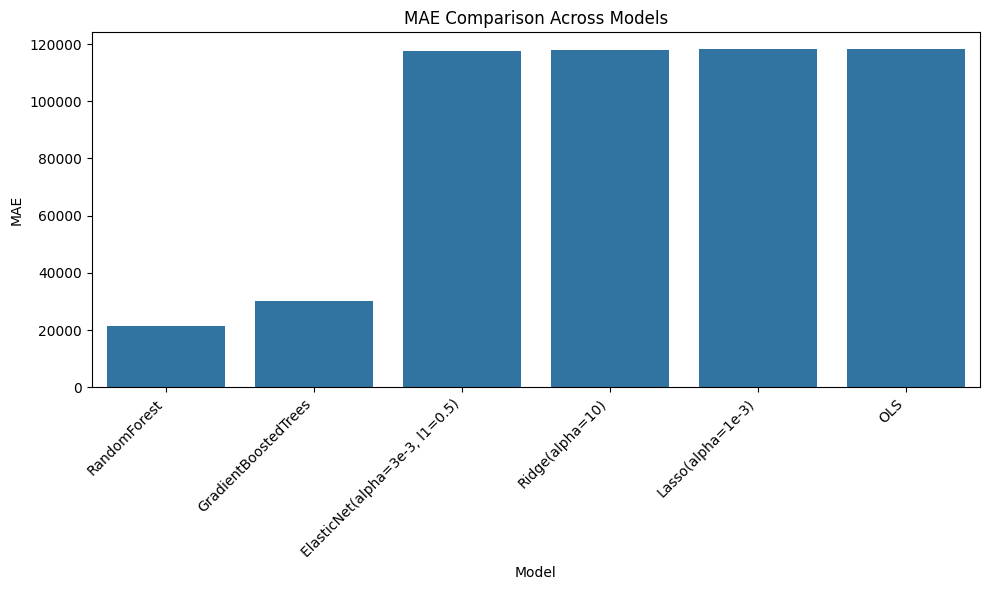

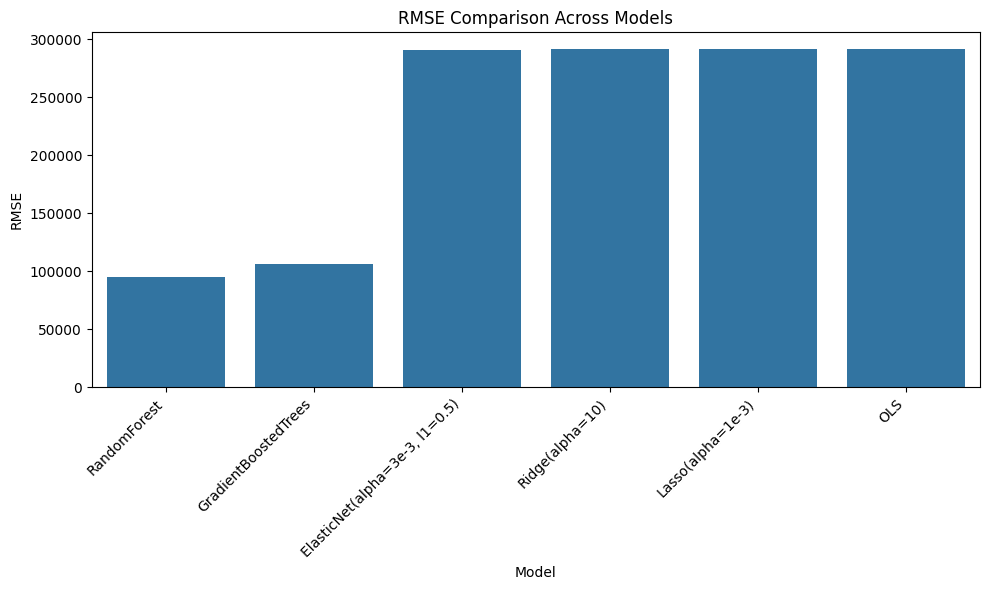

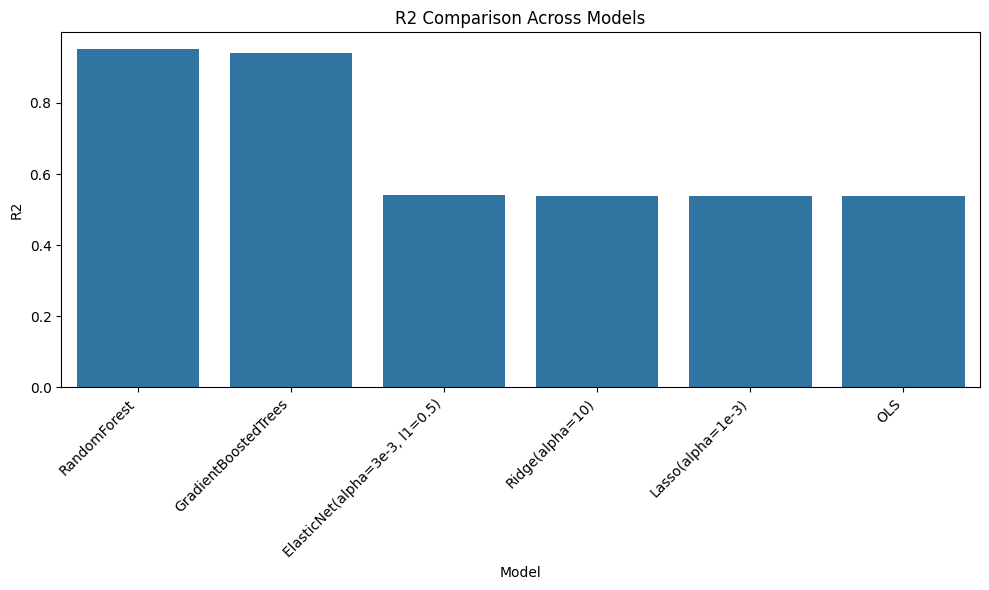

In [16]:
# Compare the results_df in a good visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe for easier plotting
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create bar plots for each metric
metrics_to_plot = ['MAE', 'RMSE', 'R2']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Score', data=results_melted[results_melted['Metric'] == metric], order=results_df['Model'])
    plt.title(f'{metric} Comparison Across Models')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    # save each image in path capstone_figures_model
    plt.savefig(capstone_figures_model + f'capstone_figures_model_{metric}.png')
    plt.tight_layout()
    plt.show()

## 6. Cross-Validation & Hyperparameter Tuning (GridSearchCV)

In [19]:
# ============================================================
# 6. Cross-Validation & Hyperparameter Tuning (FAST: precompute preprocessing once)
# ============================================================
# IMPORTANT: Run Section 5 first so 'preprocess', X_train/X_test, y_train/y_test exist.

from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# -----------------------------
# Precompute preprocessing ONCE
# -----------------------------
# PURPOSE: Fit the ColumnTransformer a single time on TRAIN data,
#          and reuse the transformed arrays for ALL CV searches below.
print("[6.0] Fitting preprocessing once and transforming train/test...")
preprocess_fitted = preprocess.fit(X_train, y_train)

# Xtr_pp/Xte_pp can be sparse (OneHotEncoder). All estimators below accept arrays.
Xtr_pp = preprocess_fitted.transform(X_train)
Xte_pp = preprocess_fitted.transform(X_test)

# Convert y to numpy arrays (safe for sklearn)
ytr = y_train.values if hasattr(y_train, "values") else y_train
yte = y_test.values if hasattr(y_test, "values") else y_test

# Use fewer folds to cut time (2–3 recommended). You already used 2 above, keeping same.
cv_fast = KFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)


[6.0] Fitting preprocessing once and transforming train/test...


In [20]:
# =============================================================================
# Part:1 (6a)  — FAST randomized searches for tree models (on preprocessed arrays)
# =============================================================================

# ----- Random Forest (RandomizedSearch) -----
# Stochastic subsampling via max_samples for speed with minimal accuracy loss.
print("[6a] RandomizedSearchCV for RandomForest (fast)")
rf_base = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    max_samples=0.7  # requires sklearn >= 0.22
)

rf_dist = {
    'n_estimators':     [150, 250, 350, 450],
    'max_depth':        [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features':     ['sqrt', 0.6, 0.8]
}

rf_rs = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_dist,
    n_iter=10,                               # ~10 combos only
    cv=cv_fast,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=1
)
rf_rs.fit(Xtr_pp, ytr)
print('Best RF (fast):', rf_rs.best_params_, 'MAE:', -rf_rs.best_score_)

best_rf = rf_rs.best_estimator_
results.append(evaluate_model(best_rf, 'RF(RandomizedSearch, precomputed)', Xtr_pp, ytr, Xte_pp, yte))

# ----- Gradient Boosted Trees (RandomizedSearch) -----
print("[6a] RandomizedSearchCV for GradientBoostingRegressor (fast)")
gbdt_base = GradientBoostingRegressor(random_state=RANDOM_SEED, subsample=0.7)

gbdt_dist = {
    'n_estimators':    [200, 300, 400],
    'learning_rate':   [0.03, 0.05, 0.1],
    'max_depth':       [2, 3],
    'min_samples_leaf':[1, 3, 5]
}

gbdt_rs = RandomizedSearchCV(
    estimator=gbdt_base,
    param_distributions=gbdt_dist,
    n_iter=12,
    cv=cv_fast,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=1
)
gbdt_rs.fit(Xtr_pp, ytr)
print('Best GBDT (fast):', gbdt_rs.best_params_, 'MAE:', -gbdt_rs.best_score_)

best_gbdt = gbdt_rs.best_estimator_
results.append(evaluate_model(best_gbdt, 'GBDT(RandomizedSearch, precomputed)', Xtr_pp, ytr, Xte_pp, yte))


[6a] RandomizedSearchCV for RandomForest (fast)
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best RF (fast): {'n_estimators': 350, 'min_samples_leaf': 2, 'max_features': 0.8, 'max_depth': None} MAE: 7754.225788943989
[RF(RandomizedSearch, precomputed)]
  Train: {'MAE': 3501.001142157703, 'RMSE': 8626.7651937162, 'R2': 0.999149206683247}
  Test : {'MAE': 20971.86824266335, 'RMSE': 98372.71394726206, 'R2': 0.9474436104828766}
[6a] RandomizedSearchCV for GradientBoostingRegressor (fast)
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best GBDT (fast): {'n_estimators': 300, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1} MAE: 10462.463071600068
[GBDT(RandomizedSearch, precomputed)]
  Train: {'MAE': 9320.100189714298, 'RMSE': 13619.643606263508, 'R2': 0.9978793958771417}
  Test : {'MAE': 20787.33238494956, 'RMSE': 78275.89362142171, 'R2': 0.9667239103768963}


In [23]:
# =============================================================================
# Part:2 (6b)  — Linear models using CV on precomputed arrays
# =============================================================================
# For linear regularized models, scikit-learn provides CV-optimized estimators
# (RidgeCV/LassoCV/ElasticNetCV) that run MUCH faster than GridSearchCV.

print("[6b] RidgeCV / LassoCV / ElasticNetCV (fast linear CV)")

# RidgeCV with your alpha grid
ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=cv_fast)
ridge_cv.fit(Xtr_pp, ytr)
print("Best Ridge alpha:", ridge_cv.alpha_)
results.append(evaluate_model(ridge_cv, 'RidgeCV(precomputed)', Xtr_pp, ytr, Xte_pp, yte))

# LassoCV (wider alpha grid recommended; keep max_iter robust)
lasso_cv = LassoCV(alphas=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
                   cv=cv_fast, max_iter=5000, random_state=RANDOM_SEED)
lasso_cv.fit(Xtr_pp, ytr)
print("Best Lasso alpha:", lasso_cv.alpha_)
results.append(evaluate_model(lasso_cv, 'LassoCV(precomputed)', Xtr_pp, ytr, Xte_pp, yte))

# ElasticNetCV (mix L1/L2)
enet_cv = ElasticNetCV(alphas=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
                       l1_ratio=[0.2, 0.5, 0.8],
                       cv=cv_fast, max_iter=5000, random_state=RANDOM_SEED)
enet_cv.fit(Xtr_pp, ytr)
print("Best ENet alpha:", enet_cv.alpha_, "l1_ratio:", enet_cv.l1_ratio_)
results.append(evaluate_model(enet_cv, 'ElasticNetCV(precomputed)', Xtr_pp, ytr, Xte_pp, yte))

# (Optional) If you still want small GridSearches for trees, keep them BUT on preprocessed arrays:
# Tiny RF grid (precomputed)
# rf_g = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_samples=0.7),
#     param_grid={'n_estimators':[200, 350], 'max_depth':[None, 15]},
#     cv=cv_fast, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1
# )
# rf_g.fit(Xtr_pp, ytr)
# print('Best RF(grid small):', rf_g.best_params_, 'MAE:', -rf_g.best_score_)
# results.append(evaluate_model(rf_g.best_estimator_, 'RF(Grid small, precomputed)', Xtr_pp, ytr, Xte_pp, yte))

# Tiny GBDT grid (precomputed)
# gbdt_g = GridSearchCV(
#     estimator=GradientBoostingRegressor(random_state=RANDOM_SEED, subsample=0.7),
#     param_grid={'n_estimators':[200, 300], 'learning_rate':[0.05, 0.1], 'max_depth':[2]},
#     cv=cv_fast, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1
# )
# gbdt_g.fit(Xtr_pp, ytr)
# print('Best GBDT(grid small):', gbdt_g.best_params_, 'MAE:', -gbdt_g.best_score_)
# results.append(evaluate_model(gbdt_g.best_estimator_, 'GBDT(Grid small, precomputed)', Xtr_pp, ytr, Xte_pp, yte))

[6b] RidgeCV / LassoCV / ElasticNetCV (fast linear CV)
Best Ridge alpha: 1.0
[RidgeCV(precomputed)]
  Train: {'MAE': 86058.23772808048, 'RMSE': 156403.54228250834, 'R2': 0.7203458396165529}
  Test : {'MAE': 118154.43257409689, 'RMSE': 291500.45137889136, 'R2': 0.5385180917584496}
Best Lasso alpha: 0.01
[LassoCV(precomputed)]
  Train: {'MAE': 86060.28514054917, 'RMSE': 156403.5333654197, 'R2': 0.7203458715045885}
  Test : {'MAE': 118170.84562883669, 'RMSE': 291523.1344958748, 'R2': 0.5384462685050802}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137918177348534.31, tolerance: 169943943197.95035
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237929705530348.9, tolerance: 169943943197.95035
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1090239418137.0625, tolerance: 169823771277.8596
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergenc

Best ENet alpha: 0.0005 l1_ratio: 0.5
[ElasticNetCV(precomputed)]
  Train: {'MAE': 86042.41689378028, 'RMSE': 156404.26363091657, 'R2': 0.720343260026018}
  Test : {'MAE': 118022.43206587476, 'RMSE': 291316.02450450155, 'R2': 0.5391018489490571}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.753e+14, tolerance: 3.398e+11
  model = cd_fast.enet_coordinate_descent(


In [30]:
# ============================================================
# Part:3 (6c)  — Final Step — Save fitted preprocessing transformer for reuse
# ============================================================
# PURPOSE: Store the fitted ColumnTransformer so we can reload it
#          in 03_scenario_analysis.ipynb without re-fitting.

import joblib
import os

# Define save path (consistent with your project folders)
preprocess_path = capstone_data_base_path + "preprocess_fitted.pkl"

# Ensure directory exists
os.makedirs(os.path.dirname(preprocess_path), exist_ok=True)

# Save fitted transformer
joblib.dump(preprocess_fitted, preprocess_path)
print(f"✅ Fitted transformer saved successfully at:\n{preprocess_path}")

# (Optional sanity check)
# To reload later in 03_scenario_analysis.ipynb:
# from joblib import load
# preprocess_fitted = load(preprocess_path)
# print('Transformer reloaded successfully.')

✅ Fitted transformer saved successfully at:
/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/preprocess_fitted.pkl


## 7. Optional Classification View (Buy cheaper = 1 if NPV delta < 0)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

y_cls = (y < 0).astype(int)

logit = Pipeline([('pre', preprocess), ('mdl', LogisticRegression(max_iter=2000, class_weight='balanced'))])
logit.fit(X_train, (y_train < 0).astype(int))

proba = logit.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)
print('Accuracy: {:.6f}'.format(accuracy_score((y_test < 0).astype(int), pred)))
print('ROC AUC: {:.6f}'.format(roc_auc_score((y_test < 0).astype(int), proba)))
print(confusion_matrix((y_test < 0).astype(int), pred))
print(classification_report((y_test < 0).astype(int), pred))

Accuracy: 0.963445
ROC AUC: 0.990760
[[24341  1064]
 [  436 15193]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     25405
           1       0.93      0.97      0.95     15629

    accuracy                           0.96     41034
   macro avg       0.96      0.97      0.96     41034
weighted avg       0.96      0.96      0.96     41034



## 8. Explainability (coefficients & permutation importance)

In [28]:

# Linear coefficients (on preprocessed space are not directly mapped to raw features).
# For a quick proxy, fit a simple linear model on imputed+scaled numeric only
from sklearn.pipeline import make_pipeline

simple_num = X_train.select_dtypes(include=[np.number]).columns.tolist()
lin_simple = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LinearRegression())
lin_simple.fit(X_train[simple_num], y_train)
coef_df = pd.DataFrame({'feature': simple_num, 'coef': lin_simple.named_steps['linearregression'].coef_})    .sort_values('coef', key=np.abs, ascending=False)
display(coef_df.head(15))

# Permutation importance for RF (model-agnostic)
try:
    from sklearn.inspection import permutation_importance
    perm = permutation_importance(rf, X_test, y_test, n_repeats=5, random_state=RANDOM_SEED, n_jobs=-1)
    imp = pd.DataFrame({'feature': X_test.columns, 'importance': perm.importances_mean})        .sort_values('importance', ascending=False)
    display(imp.head(15))
except Exception as e:
    print('Permutation importance failed:', e)


,feature,coef
4,property_tax_dollar,173973.7305
6,median_price_growth,-115840.5537
8,growth_spread,89302.2357
7,median_rent_growth,-73224.6424
1,median_rent,-67982.3630
5,price_to_rent_years,-43119.5547
3,tax_rate_3yr_avg,-28473.5236
2,mortgage_rate,3006.1068
0,median_price,-817.8747


,feature,importance
6,median_price_growth,1.5029
0,median_price,0.3089
4,property_tax_dollar,0.0291
2,mortgage_rate,0.0138
5,price_to_rent_years,0.0082
1,median_rent,0.0018
7,median_rent_growth,0.0013
8,growth_spread,0.0012
3,tax_rate_3yr_avg,-0.0000


## 9. Persist Artifacts

In [31]:
# 9.1 PURPOSE: Save the trained models and configuration for later use (e.g., scenario analysis).

import joblib, json

# Save each trained model pipeline
joblib.dump(ols, ARTIFACTS/'model_ols.joblib')
joblib.dump(ridge, ARTIFACTS/'model_ridge.joblib')
joblib.dump(lasso, ARTIFACTS/'model_lasso.joblib')
joblib.dump(enet, ARTIFACTS/'model_elasticnet.joblib')
joblib.dump(rf, ARTIFACTS/'model_rf.joblib')
joblib.dump(gbdt, ARTIFACTS/'model_gbdt.joblib')

# Save the configuration dictionary
with open(ARTIFACTS/'config.json','w') as f:
    json.dump(CONFIG, f, indent=2)

print('Artifacts saved to', ARTIFACTS)

Artifacts saved to /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/artifacts


In [32]:
# 9.2 Save Scenario Input Frame (v2) for 03_scenario_analysis
import os
import pandas as pd

# Choose a save directory (Drive if available; else ARTIFACTS)
try:
    capstone_data_base_path
    SAVE_DIR = capstone_data_base_path
except NameError:
    SAVE_DIR = str(ARTIFACTS) + "/"

os.makedirs(SAVE_DIR, exist_ok=True)

cols_keep = [
    'zip','state','Metro','date','year',
    'median_price','median_rent','mortgage_rate',
    'tax_rate_3yr_avg','insurance_pct','maintenance_pct',
]
for opt in ['hoa_monthly','price_to_rent_years','property_tax_dollar','hoa_annual','growth_spread',
            'npv_buy','npv_rent','delta_buy_minus_rent','mortgage_monthly','sale_price_yearH']:
    if opt in df_fe.columns: cols_keep.append(opt)

cols_keep = [c for c in cols_keep if c in df_fe.columns]
model_training_frame_v2 = df_fe[cols_keep].copy()
model_training_frame_v2['buy_cheaper'] = (model_training_frame_v2['delta_buy_minus_rent'] < 0).astype(int)

csv_path = os.path.join(SAVE_DIR, "model_training_frame_v2.csv")
model_training_frame_v2.to_csv(csv_path, index=False)
print("✅ Saved scenario frame:", csv_path)


✅ Saved scenario frame: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/model_training_frame_v2.csv



## 10. Next Steps
- Tune model grids further (within course scope) and select a **champion** by MAE/RMSE.  
- Export per-ZIP predictions to CSV and feed into **03_scenario_analysis.ipynb** for rate/tax/insurance sweeps.  
- Consider **threshold tuning** for the classification decision based on risk tolerance and business rules.
